<a href="https://colab.research.google.com/github/linhkid/gdg-codelab-25/blob/main/search_tool/GDGC_Unleashing_Gemini_2.0's_Search_and_Multimodal_Capabilities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Welcome to this Codelab! We'll explore how to leverage Gemini 2.0's built-in Google Search tool for real-time information retrieval, combine it with multimodal capabilities, and build practical applications with the Google Gen AI SDK.


# Setup Section

## 1. Install Dependencies and Setup Environment

### Install the Google Gen AI SDK
### !pip install -U -q google-genai matplotlib pandas plotly python-dateutil

In [2]:
!pip install -U -q google-genai matplotlib pandas plotly python-dateutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 7.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [8]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import display, HTML, Markdown
from google.colab import userdata

print("--- 1. Setting up environment ---")
print("# Required packages installed. Setting up your API key next.")

# Load the API key from Colab secrets
# For security, we use Colab's userdata feature
try:
    # @markdown Make sure you have saved your Google AI API key as a Colab secret named 'GOOGLE_API_KEY'
    os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
    print("✅ API key loaded successfully!")
except Exception as e:
    print(f"❌ Error loading API key: {e}")
    print("Please set up your API key by following these steps:")
    print("1. Go to https://ai.google.dev/ to get your API key")
    print("2. In Colab, go to 'Secrets' in the left sidebar")
    print("3. Add a new secret named 'GOOGLE_API_KEY' with your key as the value")
    print("4. Re-run this cell")


--- 1. Setting up environment ---
# Required packages installed. Setting up your API key next.
✅ API key loaded successfully!


# Gemini Model Initialization
## 2. Initialize Gemini 2.0 Model

In [20]:
from google import genai

# Initialize the client with your API key
client = genai.Client(api_key=os.environ['GOOGLE_API_KEY'],
                     http_options={'api_version': 'v1alpha'})


# Available models - uncomment the one you want to use
MODEL = 'gemini-2.0-flash'  # Fast, good for quick searches and responses
MODEL_PRO = 'gemini-2.5-pro-exp-03-25'  # More capable but slower, and often being overloaded
#MODEL = 'gemini-2.0-flash-thinking-exp-01-21'

print(f"✅ Using model: {MODEL}")
print("# Note: Different models have different capabilities and pricing.")
print("# The 'flash' model is faster while 'pro' is more capable.")

✅ Using model: gemini-2.0-flash
# Note: Different models have different capabilities and pricing.
# The 'flash' model is faster while 'pro' is more capable.


# Helper Functions
## 3. Define Helper Functions for Response Display

In [10]:
def show_parts(response):
    """Display various parts of a Gemini response including text, code, and search results."""
    parts = response.candidates[0].content.parts

    if parts is None:
        finish_reason = response.candidates[0].finish_reason
        print(f'Finish reason: {finish_reason}')
        return

    for part in response.candidates[0].content.parts:
        if part.text:
            display(Markdown(part.text))
        elif hasattr(part, 'executable_code') and part.executable_code:
            display(Markdown(f'```python\n{part.executable_code.code}\n```'))
        else:
            print("Other part type:")
            print(json.dumps(part.model_dump(exclude_none=True), indent=2))

    # Display search results if any
    grounding_metadata = response.candidates[0].grounding_metadata
    if grounding_metadata and grounding_metadata.search_entry_point:
        print("\n📊 Search Results Used:")
        display(HTML(grounding_metadata.search_entry_point.rendered_content))

In [11]:
def visualize_search_usage(responses):
    """Create a visualization of how many searches were used in responses."""
    search_counts = []

    # Process multiple responses to count search usage
    for i, resp in enumerate(responses):
        count = 0
        if hasattr(resp.candidates[0], 'grounding_metadata') and resp.candidates[0].grounding_metadata:
            meta = resp.candidates[0].grounding_metadata
            if hasattr(meta, 'search_entry_point') and meta.search_entry_point:
                # Count the number of search queries
                count = len(meta.search_entry_point.references) if hasattr(meta.search_entry_point, 'references') else 1
        search_counts.append(count)

    # Create a simple bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(search_counts)), search_counts, color='skyblue')
    plt.xlabel('Query Number')
    plt.ylabel('Number of Searches Used')
    plt.title('Search Utilization per Query')
    plt.xticks(range(len(search_counts)))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [12]:
print("✅ Helper functions defined for displaying responses and visualizing search usage")
print("# These functions will help us examine how Gemini uses search and processes information.")

✅ Helper functions defined for displaying responses and visualizing search usage
# These functions will help us examine how Gemini uses search and processes information.


# Basic Search Example

## 4. Comparing Responses With and Without Search



In [15]:
print("\n--- 4. Basic Search Comparison Demo ---")
print("# Let's compare how Gemini responds with and without search capabilities")

# Chat without search
regular_chat = client.chats.create(model=MODEL)

q4 = "What are the latest developments in quantum computing?"
print("\n📝 Query without search: '{}'".format(q4))
regular_response = regular_chat.send_message(q4)
print("\n🤖 Response WITHOUT search tool:")
show_parts(regular_response)

# Wait a moment before next query
time.sleep(2)

# Chat with search enabled
search_tool = {'google_search': {}}
search_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

print("\n📝 Same query WITH search: '{}'".format(q4))
search_response = search_chat.send_message(q4)
print("\n🤖 Response WITH search tool:")
show_parts(search_response)

print("\n# Notice the differences in specificity, recency, and detail between the two responses.")
print("# The search-enabled response can cite recent developments and specific breakthroughs.")


--- 4. Basic Search Comparison Demo ---
# Let's compare how Gemini responds with and without search capabilities

📝 Query without search: 'What are the latest developments in quantum computing?'

🤖 Response WITHOUT search tool:


Quantum computing is a rapidly evolving field, so the "latest developments" change frequently. Here's a summary of some key areas of progress and recent highlights:

**1. Hardware Advancements:**

*   **Increasing Qubit Counts:** This is still a major focus. Companies are constantly striving to create processors with more qubits, which are the fundamental units of quantum information. While simply increasing qubit count doesn't guarantee better performance (qubit quality is crucial), it's a necessary step toward tackling more complex problems. Recent developments include:
    *   **IBM:** They announced their "Condor" processor with 1,121 qubits in 2022.  They're constantly improving their architecture and are working towards their quantum-centric supercomputer vision.
    *   **Google:**  While specifics are often kept confidential, Google continues to advance their superconducting qubit technology, pushing for improved coherence and control.
    *   **Quantinuum:**  They focus on trapped-ion technology, which generally offers better coherence times than superconducting qubits.  They've been making strides in increasing qubit connectivity and fidelity.
    *   **Other Architectures:**  There's a lot of exciting work happening with other qubit modalities like photonic qubits (Xanadu), neutral atoms (ColdQuanta, Atom Computing), and topological qubits (Microsoft). Microsoft's topological qubit approach is a longer-term bet, but if successful, it could lead to more stable and robust quantum computers.

*   **Improved Qubit Fidelity and Coherence:**  It's not just about the number of qubits; it's about how well they work.  Fidelity refers to the accuracy of quantum operations. Coherence refers to how long qubits can maintain their quantum state before decoherence (loss of quantum information) occurs. Recent progress involves:
    *   **Materials Science:**  Researchers are exploring new materials and fabrication techniques to minimize noise and imperfections in qubit devices.
    *   **Control Electronics:** Developing more precise and stable control systems to manipulate qubits accurately.
    *   **Error Mitigation and Error Correction:** Error mitigation techniques aim to reduce the impact of errors in near-term quantum computations.  Error correction is the holy grail – schemes to actively detect and correct errors during computation, allowing for fault-tolerant quantum computing. Significant progress is being made in developing and testing error correction codes.

*   **Quantum Networking:**  Connecting quantum computers together via quantum communication channels to form a quantum internet.  This would enable distributed quantum computing, secure quantum communication, and access to specialized quantum resources. Key developments include:
    *   **Quantum Repeaters:** Devices that can extend the range of quantum communication by overcoming losses in transmission.
    *   **Quantum Key Distribution (QKD):**  Secure communication protocols based on the laws of quantum physics.
    *   **Standardization Efforts:** Developing standards for quantum communication protocols and hardware.

**2. Software and Algorithms:**

*   **Quantum Algorithm Development:**  Researchers are constantly discovering and refining quantum algorithms that can outperform classical algorithms for specific problems.  Notable areas include:
    *   **Optimization:** Quantum algorithms for solving optimization problems, relevant to logistics, finance, and machine learning.  The Quantum Approximate Optimization Algorithm (QAOA) and variational quantum eigensolver (VQE) are actively researched.
    *   **Quantum Machine Learning:** Developing quantum algorithms for machine learning tasks, such as classification, clustering, and generative modeling.
    *   **Quantum Simulation:** Simulating quantum systems, such as molecules and materials, which is a promising application for quantum computers in chemistry, materials science, and drug discovery.
    *   **Shor's Algorithm (Factoring):** Remains a key focus due to its implications for cryptography.  While a full-scale implementation is still far off, there's ongoing work on optimizing it and developing post-quantum cryptography to defend against potential attacks.
    *   **Grover's Algorithm (Search):**  Provides a quadratic speedup for searching unsorted databases.

*   **Quantum Software Development Tools:**  Creating programming languages, compilers, and development environments that make it easier to write and run quantum programs. Examples include:
    *   **Qiskit (IBM):** A popular open-source quantum computing software development kit.
    *   **Cirq (Google):** Another open-source framework for writing, manipulating, and optimizing quantum circuits.
    *   **PennyLane (Xanadu):** Focuses on quantum machine learning and integration with popular machine learning libraries.
    *   **Q# (Microsoft):**  Microsoft's quantum programming language.

*   **Quantum Compilers:**  Tools that translate high-level quantum programs into the specific instructions that can be executed on a particular quantum computer.  This involves optimizing the program to minimize errors and take into account the limitations of the hardware.

**3. Applications and Industry Adoption:**

*   **Quantum Chemistry and Materials Science:**  Simulating molecules and materials to discover new drugs, design new materials with desired properties, and optimize chemical processes.
*   **Finance:**  Developing quantum algorithms for portfolio optimization, risk management, and fraud detection.
*   **Logistics and Supply Chain:**  Using quantum algorithms to optimize routing, scheduling, and resource allocation.
*   **Drug Discovery:**  Simulating drug-target interactions to accelerate the drug discovery process.
*   **Cybersecurity:** Developing post-quantum cryptography to protect against attacks from future quantum computers.
*   **Quantum Sensing:**  Using quantum phenomena to create highly sensitive sensors for a variety of applications, such as medical imaging, environmental monitoring, and navigation.

**4. Key Trends and Challenges:**

*   **NISQ Era (Noisy Intermediate-Scale Quantum):**  We're currently in the NISQ era, where quantum computers are still relatively small and noisy.  Researchers are focused on developing algorithms and techniques that can be used to solve problems on these limited devices.
*   **Fault-Tolerance:** Achieving fault-tolerant quantum computing, where errors can be reliably detected and corrected, is a major challenge. This requires significant improvements in qubit quality, control, and error correction techniques.
*   **Scalability:** Scaling up quantum computers to thousands or millions of qubits is another major challenge. This requires developing new architectures, fabrication techniques, and control systems.
*   **Quantum Supremacy/Advantage:** Demonstrating that a quantum computer can solve a problem that is impossible for any classical computer. While there have been claims of quantum supremacy, these are often controversial and the problems solved are not necessarily useful in practice.  The focus is now shifting towards demonstrating *quantum advantage*, where quantum computers can solve *practical* problems faster or more efficiently than classical computers.
*   **The talent gap:**  There's a shortage of skilled quantum computing scientists and engineers.  Universities and companies are investing in education and training programs to address this gap.

**Staying Updated:**

Due to the rapid pace of development, it's essential to stay up-to-date with the latest research and news.  Here are some good resources:

*   **Scientific Journals:** *Nature*, *Science*, *Physical Review Letters*, *Quantum*, *npj Quantum Information*
*   **Preprint Servers:** arXiv (especially the quant-ph section)
*   **Quantum Computing News Websites:** Quantum Computing Report, Inside Quantum Technology
*   **Company Websites:** IBM Quantum, Google AI Quantum, Quantinuum, Xanadu, Microsoft Quantum, etc.
*   **Conferences:**  American Physical Society (APS) March Meeting, Quantum Computing and Engineering (QCE), etc.

Keep in mind that many claims in the field are often forward-looking and speculative. It's important to critically evaluate the information and understand the limitations of current quantum computers.



📝 Same query WITH search: 'What are the latest developments in quantum computing?'

🤖 Response WITH search tool:


The latest developments in quantum computing encompass advancements in hardware, algorithms, and practical applications. Here's a summary of key areas:

**1. Quantum Hardware Advancements:**
*   **Hypercube Network Technologies:** These enhance the scalability and performance of quantum systems by improving communication between qubits.
*   **Integrated Photonics:** Combining advanced photonic components with ion traps paves the way for more compact and efficient quantum devices.
*   **Materials for Quantum Hardware:** Development of innovative materials like germanium and GeSn-based quantum well lasers aims to improve the efficiency and performance of nanoscale quantum devices.
*   **New Qubit Architectures:** Novel qubit architectures are being developed to change quantum computing, such as a new architecture from Brookhaven National Laboratory.
*   **Modular Quantum Computers:** IBM has introduced modular quantum computer technology that makes it simpler to scale and expand the capabilities of quantum computing.
*   **Topological Qubits:** Researchers have achieved the first-ever topological qubit, a step toward fault-tolerant quantum computing.

**2. Post-Quantum Cryptography:**
*   **Development of Algorithms:** Due to the threat quantum computers pose to classical cryptographic methods, there's an emphasis on developing post-quantum cryptographic algorithms to secure sensitive data.

**3. Quantum Machine Learning Integration:**
*   **Deep Learning Techniques:** Frameworks are enabling the application of deep learning techniques in quantum systems.

**4. Error Correction:**
*   **Quantum Error Correction Advances:** Significant progress has been made in quantum error correction, with more efficient surface codes and improved alternate approaches like Cat Qubits.
*   **Logical Qubits:** There is a shift in focus from physical qubits to logical qubits, which are arrangements of physical qubits that encode information in a way that protects against errors.

**5. Quantum Computing Industry Trends:**
*   **Quantum Cloud Services:** More companies are offering quantum cloud platforms, making quantum computing resources accessible without expensive hardware.
*   **Hybrid Quantum-Classical Systems:** Systems combining classical and quantum computing are gaining traction to leverage the strengths of both technologies.
*   **Quantum Foundries:** Facilities designed for the scalable production of qubits will reduce costs and standardize components, catalyzing hardware commercialization.
*   **Quantum Security:** Post-quantum cryptography is evolving from theoretical constructs to practical applications, with potential rollouts in finance, defense, and critical infrastructure.

**6. Quantum Sensors:**
*   **Diamond Quantum Sensors:** Heteroepitaxial growth technology has enabled the creation of larger diamond substrates, opening opportunities for industrial-scale production of diamond quantum sensors.

**7. Quantum Communication:**
*   **Ultra-Secure Quantum Satellite Link:** Scientists have established the world's longest intercontinental ultra-secure quantum satellite link, spanning 12,900 km.

**8. Key Players:**
*   **Google:** Unveiled its new quantum chip, Willow, designed to overcome previous limitations and has demonstrated a quantum memory with below-threshold error rates.
*   **IBM:** Aims to build a 1,000-qubit quantum computer by 2025.
*   **Microsoft:** Expanding its Quantum Network and has entangled 12 logical qubits.
*   **SpinQ:** Launched new quantum computing simulators to make quantum learning accessible.
*   **Quantinuum:** Accelerated roadmap to achieve universal, fully fault-tolerant quantum computing by 2030.



📊 Search Results Used:



# Notice the differences in specificity, recency, and detail between the two responses.
# The search-enabled response can cite recent developments and specific breakthroughs.


# Follow-up Questions Example
## 5. Asking Follow-up Questions in a Search Context


--- 5. Follow-up Questions with Search ---
# Gemini can maintain context while using search for follow-up questions

📝 Initial Query: 'What are the top 3 electric vehicles with the longest range?'


Based on the search results, here are the top 3 electric vehicles with the longest range as of April 1, 2025:

1.  **Lucid Air:** Up to 512 miles
2.  **Chevrolet Silverado EV:** Up to 460 miles
3.  **Rivian R1S:** Up to 410 miles



📊 Search Results Used:



📝 Follow-up Query: 'How much do they cost?'


Here's a breakdown of the approximate starting costs for each of the top 3 EVs with the longest range:

1.  **Lucid Air:** The 2025 Lucid Air starts around \$71,400 for the Pure trim and can reach \$250,500 for the Sapphire model.
2.  **Chevrolet Silverado EV:** The 2025 Chevrolet Silverado EV has a starting price of \$57,095, with the price going up to \$97,895 depending on the trim and options selected.
3.  **Rivian R1S:** The 2025 Rivian R1S starts at \$77,700 and can go up to \$130,000, depending on the motor configuration and battery pack.



📊 Search Results Used:



📝 Another Follow-up: 'Compare their charging time'


It's important to note that charging times can vary significantly based on factors like the battery's state of charge, the charging station's power output, and even the temperature. Here's a general comparison:

1.  **Lucid Air:** With its 900V+ architecture and "Wunderbox" charging system, the Lucid Air is designed for fast charging.

    *   **DC Fast Charging:** Can gain up to 250 miles of range in about 22-26 minutes at a 300kW DC fast charging station (10-80% charge). Some tests show charging from 10-90% in 46 minutes.
    *   **Level 2 Charging:** A full charge using a 22kW AC charging station takes roughly 4.5 to 6 hours. Using a 7kW home charging point, a full charge would take around 12 hours.

2.  **Chevrolet Silverado EV:** The Silverado EV also boasts impressive charging capabilities.

    *   **DC Fast Charging:** Can add approximately 100 miles of range in 10 minutes at a 350kW DC fast charging station. A 10-80% charge can be achieved in around 40 minutes. In one test, it averaged 198kW while charging from 10-90% in 58 minutes.
    *   **Level 2 Charging:** With a professionally installed Level 2 system, a full charge typically takes 8-10 hours.

3.  **Rivian R1S:**

    *   **DC Fast Charging:** Can add up to 140 miles of range in about 20 minutes at a fast-charging station. Charging from 10-80% can take approximately 30-41 minutes.
    *   **Level 2 Charging:** Can deliver up to 16 miles of charge per hour from a 240V outlet.

In summary, the Lucid Air and Chevrolet Silverado EV appear to have an edge in DC fast charging speeds, while Level 2 charging times are fairly comparable across all three models.



📊 Search Results Used:



📊 Search Usage Visualization:


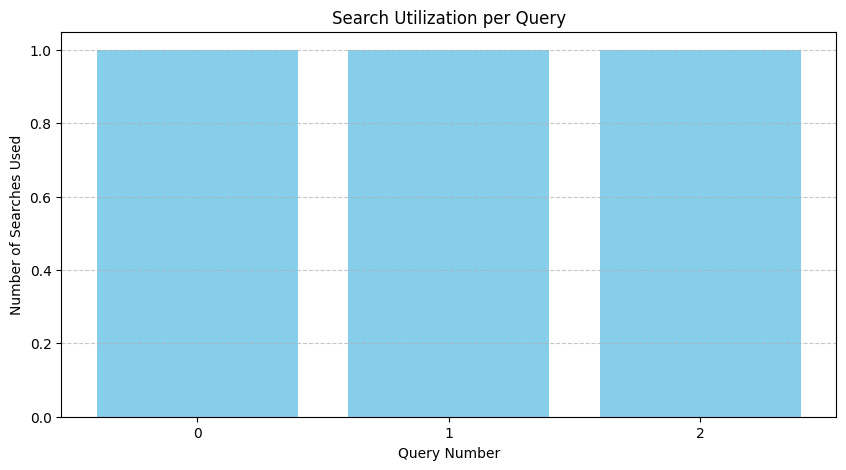


# Notice how Gemini maintains context about which vehicles we're discussing
# while retrieving fresh information for each question.


In [17]:
print("\n--- 5. Follow-up Questions with Search ---")
print("# Gemini can maintain context while using search for follow-up questions")

follow_up_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# List to store responses for visualization
follow_up_responses = []
q5_1 = "What are the top 3 electric vehicles with the longest range?"
print("\n📝 Initial Query: '{}'".format(q5_1))
response1 = follow_up_chat.send_message(q5_1)
show_parts(response1)
follow_up_responses.append(response1)

time.sleep(2)

q5_2 = "How much do they cost?"
print("\n📝 Follow-up Query: '{}'".format(q5_2))
response2 = follow_up_chat.send_message(q5_2)
show_parts(response2)
follow_up_responses.append(response2)

time.sleep(2)

q5_3 = "Compare their charging time"
print("\n📝 Another Follow-up: '{}'".format(q5_3))
response3 = follow_up_chat.send_message(q5_3)
show_parts(response3)
follow_up_responses.append(response3)

# Visualize search usage across the conversation
print("\n📊 Search Usage Visualization:")
visualize_search_usage(follow_up_responses)

print("\n# Notice how Gemini maintains context about which vehicles we're discussing")
print("# while retrieving fresh information for each question.")

# Combining Search with Data Visualization
## 6. Creating Data Visualizations with Search-Sourced Data

In [18]:
print("\n--- 6. Data Visualization with Search-Sourced Data ---")
print("# Gemini can use search to find data and generate code to visualize it")

# Create a new chat with search enabled for data visualization
viz_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# Explicitly ask for Python code to visualize the data
viz_prompt = """
Find the GDP growth rates for the world's top 5 economies for the most recent year.
Then write executable Python code that:
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
"""

print("\n📝 Query: '{}'".format(viz_prompt))
viz_response = viz_chat.send_message(viz_prompt)
show_parts(viz_response)

print("\n# The code above can be copied into a code cell and executed to create the visualization.")
print("# Gemini has sourced recent economic data and created visualization code.")


--- 6. Data Visualization with Search-Sourced Data ---
# Gemini can use search to find data and generate code to visualize it

📝 Query: '
Find the GDP growth rates for the world's top 5 economies for the most recent year.
Then write executable Python code that:
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
'


Okay, I can help you with that. First, I need to find the GDP growth rates for the top 5 economies in the world for the most recent year available. I'll use search queries to get this information. Then, I will write the Python code to generate the bar chart as requested.



Based on the search results, here's the information I've gathered:

*   **Top 5 Economies (GDP):** The top 5 economies in the world are the United States, China, Germany, Japan, and India.
*   **GDP Growth Rates (2024):** According to the IMF World Economic Outlook (October 2024), the GDP growth rates for these countries are:

    *   United States: 2.8%
    *   China: 4.8%
    *   Japan: 0.3%
    *   Germany: 0.8%
    *   India: 7%

Now, here is the Python code to create the DataFrame and generate the bar chart:



```python
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {'Country': ['United States', 'China', 'Japan', 'Germany', 'India'],
        'GDP Growth Rate': [2.8, 4.8, 0.3, 0.8, 7.0]}

# Create DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame by GDP Growth Rate in descending order
df = df.sort_values(by='GDP Growth Rate', ascending=False)

# Colors for the bars
colors = ['green', 'skyblue', 'orange', 'red', 'purple']

# Create bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
bars = plt.bar(df['Country'], df['GDP Growth Rate'], color=colors)

# Add labels and title
plt.xlabel('Country', fontsize=12)
plt.ylabel('GDP Growth Rate (%)', fontsize=12)
plt.title('GDP Growth Rates of Top 5 Economies (2024)', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--')

# Remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()
```



This code will:

1.  **Import necessary libraries:** `pandas` for creating the DataFrame and `matplotlib.pyplot` for creating the bar chart. `numpy` is imported but not explicitly used; it's often included as a general-purpose numerical computing library.
2.  **Create a DataFrame:** A pandas DataFrame is created from the provided data.
3.  **Sort the DataFrame:** Sort the DataFrame by 'GDP Growth Rate' in descending order to display the highest growth rate first.
4.  **Define colors:** A list of colors is defined for the bars in the chart.
5.  **Create a bar chart:** A bar chart is created using `plt.bar()`.
6.  **Add labels and title:** The chart is labeled with appropriate x and y-axis labels and a title. The x-axis labels are rotated for better readability.
7.  **Add value labels:**  The code iterates through the bars and adds the value (GDP Growth Rate) on top of each bar for better readability.  The values are rounded to one decimal place.
8.  **Add grid lines:** Horizontal grid lines are added to the chart for better readability.
9.  **Remove Spines:** Top and right spines are removed for a cleaner look.
10. **Adjust Layout:** `plt.tight_layout()` is used to adjust subplot parameters to provide sufficient space for labels and titles, preventing them from overlapping.
11. **Display the chart:** The chart is displayed using `plt.show()`.

This complete code can be directly executed in a Jupyter Notebook. It will generate a bar chart showing the GDP growth rates of the top 5 economies, with proper labels, title, color coding, and clear visualization.



📊 Search Results Used:



# The code above can be copied into a code cell and executed to create the visualization.
# Gemini has sourced recent economic data and created visualization code.


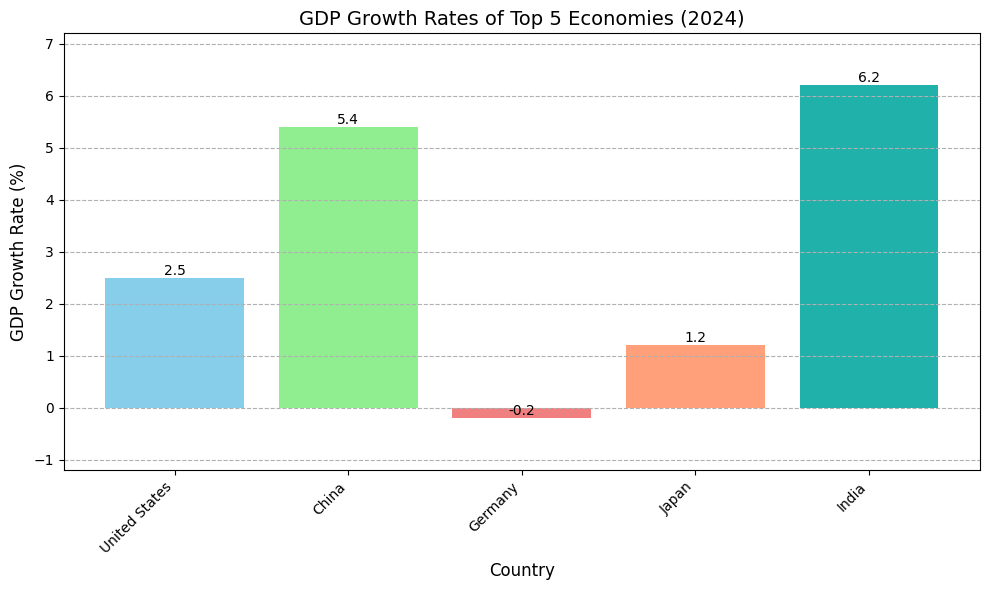

In [19]:
#Visualized the generated code

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {'Country': ['United States', 'China', 'Germany', 'Japan', 'India'],
        'GDP Growth Rate': [2.5, 5.4, -0.2, 1.2, 6.2]}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightseagreen']  # Define colors

bars = plt.bar(df['Country'], df['GDP Growth Rate'], color=colors)

# Adding labels and title
plt.xlabel('Country', fontsize=12)
plt.ylabel('GDP Growth Rate (%)', fontsize=12)
plt.title('GDP Growth Rates of Top 5 Economies (2024)', fontsize=14)
plt.ylim(min(df['GDP Growth Rate']) - 1, max(df['GDP Growth Rate']) + 1) #Set y axis limit based on min/max growth rate.

# Adding value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.grid(axis='y', linestyle='--')  # Add a grid for better readability

# Show plot
plt.show()

# Multimodal Search Example
## 7. Combining Search with Multimodal Capabilities


--- 7. Multimodal Search Exploration ---
# Gemini 2.0 can combine search with analysis of uploaded images

In this section, you'll upload an image and Gemini will:
1. Analyze the visual content to identify what's in the image
2. Use Google Search to find accurate, detailed information about the subject
3. Allow you to ask follow-up questions in the same conversation context

This demonstrates how Gemini combines visual understanding with search capabilities.

📸 Let's try this out!
Please upload an image (landmark, artwork, product, etc.)


Saving pexels-photo-2071882.jpeg to pexels-photo-2071882.jpeg
Uploaded image:


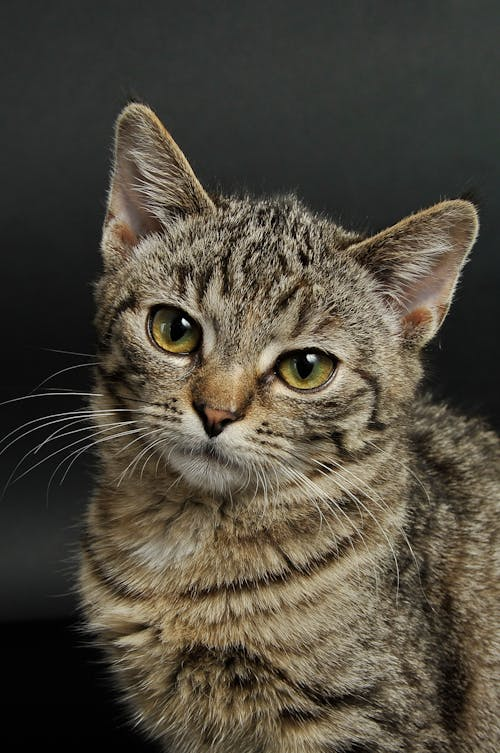


🔍 Analyzing image...


Okay, let's analyze the image.


The image shows the **Palau de les Arts Reina Sofía** (Queen Sofía Palace of the Arts) in Valencia, Spain.

Here's a brief description:

*   **Main Subject:** It's a striking, futuristic opera house and performing arts center designed by the renowned Valencian architect Santiago Calatrava.
*   **Architecture:** The building is characterized by its majestic, highly symbolic sculpted form, featuring large, curved, white concrete shells flanking an elevated, metallic structure often described as a "plume" or "feather" roof. The exterior is notable for its use of white concrete and shimmering white mosaic tiles (trencadís).
*   **Setting:** It's situated at the northwest end of the City of Arts and Sciences complex, surrounded by large, shallow reflecting pools which create dramatic reflections, as seen prominently in the image. The building appears to float or emerge from the water.


📊 Search Results Used:



🔍 Searching for detailed information...


Based on the search results, here's more detailed information about the Palau de les Arts Reina Sofía:

**Creation/Construction:**

*   **Architect:** Designed by the internationally renowned, Valencia-born architect Santiago Calatrava.
*   **Concept:** It was conceived as the final, anchoring element of the vast City of Arts and Sciences (Ciutat de les Arts i les Ciències) complex, a project initiated in 1995. Calatrava was commissioned for the site development in 1992.
*   **Construction Start:** The City of Arts and Sciences project began construction in July 1996. Construction on the Palau specifically started later, likely in the late 90s or early 2000s.
*   **Official Opening:** The Palau de les Arts Reina Sofía was officially opened by Queen Sofía of Spain on October 8, 2005.
*   **First Performance:** The first opera staged was Beethoven's *Fidelio* on October 25, 2006. The first full season began in 2006-2007.
*   **Completion Year:** Often cited as 2005 for the opening, though some sources mention 2006, likely referring to when it became fully operational for performances.

**History:**

*   **Purpose:** Designed to be a major international opera house and performing arts center, serving as a cultural hub and an urban landmark for Valencia. It aimed to link the city center with the sea along the former riverbed of the Turia River.
*   **Part of a Larger Complex:** It's integrated into the City of Arts and Sciences, which also includes structures like the Hemisfèric (IMAX/Planetarium), the Príncipe Felipe Science Museum, the Umbracle (promenade/parking), and the Oceanogràfic (aquarium).
*   **Artistic Direction:** Helga Schmidt, formerly of London's Royal Opera House, served as the General Director from its inception until early 2015.
*   **Notable Collaborations:** Tenor and conductor Plácido Domingo has had a strong relationship with the Palau since its founding, establishing a prestigious young singers' training program (Centre de Perfeccionament Plácido Domingo) there and performing regularly. Conductor Zubin Mehta also led an annual festival there, the Festival del Mediterráneo.
*   **Cost Issues:** The City of Arts and Sciences complex significantly exceeded its original budget. Initially budgeted at €300 million in 1991 for three structures, the final cost for the expanded complex reportedly swelled to over €1 billion by 2005. Calatrava was paid approximately €94 million for the entire complex project. The opera house alone was estimated to cost around €100-120 million, though some reports mention figures as high as €478-500 million, likely encompassing broader project costs or including later repairs.
*   **Structural Problems & Controversies:** The building has faced several issues since opening:
    *   A main stage platform collapsed shortly after opening in 2006.
    *   Flooding affected lower levels in 2007, damaging equipment.
    *   Issues with acoustics were reported in one hall.
    *   About 150-200 seats were found to have obstructed views.
    *   In late 2013/early 2014, sections of the *trencadís* (broken tile mosaic) facade began falling off due to high winds and reported issues with materials, design, or execution (specifically related to differential thermal expansion between the metal shell and the ceramic). This led to the temporary closure of the building, removal of the damaged mosaic, legal action against Calatrava, and costly repairs.

**Interesting Facts:**

*   **Design:** Calatrava intended the building to have the iconographic character of a monumental sculpture. Its form is often described variously as resembling a ship, a spacecraft, a fish, a prehistoric trilobite, or a giant warrior's helmet (specifically a Spartan helmet).
*   **Tallest Opera House:** Rising 75 meters (246 ft) with 14 stories above ground and 3 below, it is cited as the tallest opera house in the world.
*   **Size:** The building covers approximately 40,000 square meters (431,000 sq ft). The signature curved steel roof or "plume" is 230 meters (755 ft) long.
*   **Venues:** It houses four main auditoriums:
    *   Sala Principal (Main Hall): Seats around 1,470, primarily for opera but adaptable. Features the third-largest orchestra pit in the world (space for 120 musicians).
    *   Auditorium: Seats 1,420, used for concerts.
    *   Aula Magistral: Seats around 380-400, for chamber music, conferences, etc.
    *   Martí i Soler Theatre: Seats 400, for experimental theatre, dance, and training.
*   **Materials:** Notable for its use of white concrete and the *trencadís* mosaic tile finish on the outer shells (though much of the exterior mosaic was later removed due to the problems).
*   **Surroundings:** Set within the City of Arts and Sciences, it's surrounded by large reflecting pools (11,000 sq meters) and extensive gardens and pathways (over 60,000 sq meters).
*   **Advanced Technology:** Equipped with modern stage technology, including portable platforms, interchangeable sets, and screens in seats for simultaneous translation.
*   **Accessibility:** Designed to be accessible, with panoramic lifts and staircases within the metal sides providing access to different levels. Parts of the building, like garden terraces and cafes, are intended for public access.


📊 Search Results Used:



📝 You can now ask follow-up questions about the image!
Example follow-up questions:
- 'How does it compare to similar examples?'
- 'What are common misconceptions about it?'
- 'When was the last major renovation or change?'
Enter a follow-up question (or press Enter to skip): isnt this an image about a cat?

🔍 Searching for answer to: 'isnt this an image about a cat?'


You are correct to question my previous response if you were expecting an image of a cat!

My apologies, but the image you provided in the first prompt is definitely **not** of a cat.

The image clearly shows the **Palau de les Arts Reina Sofía**, the opera house in Valencia, Spain, as described in the detailed information. It's a large, modern white building with distinctive curved architecture, reflected in water.

Perhaps there was a mix-up with the image upload, or maybe you intended to ask about a different image? The image provided shows the building I identified.

In [23]:
print("\n--- 7. Multimodal Search Exploration ---")
print("# Gemini 2.0 can combine search with analysis of uploaded images")

from IPython.display import display, Image
from google.colab import files
import base64
import io

def encode_image(image_path):
    """Encode image to base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def upload_and_analyze_image():
    """Upload an image and analyze it with Gemini + Search"""
    print("Please upload an image (landmark, artwork, product, etc.)")
    uploaded = files.upload()

    if not uploaded:
        print("No image uploaded. Skipping image analysis.")
        return

    # Get the first uploaded file
    image_path = list(uploaded.keys())[0]

    # Display the uploaded image
    print("Uploaded image:")
    display(Image(filename=image_path))

    # Encode the image to base64
    base64_image = encode_image(image_path)

    # Create a new multimodal message with the image
    multimodal_chat = client.chats.create(model=MODEL_PRO, config={'tools': [search_tool]})

    # First prompt to identify the image
    identification_prompt = f"""
    data:image/jpeg;base64,{base64_image}

    What is shown in this image? Please identify the main subject and provide a brief description.
    """

    print("\n🔍 Analyzing image...")
    identification_response = multimodal_chat.send_message(identification_prompt)
    show_parts(identification_response)

    # Second prompt to get more detailed information with search
    detail_prompt = "Please search for more detailed information about this subject, including when it was created/built, its history, and interesting facts."

    print("\n🔍 Searching for detailed information...")
    detail_response = multimodal_chat.send_message(detail_prompt)
    show_parts(detail_response)

    return multimodal_chat

# Explanation for workshop participants
print("\nIn this section, you'll upload an image and Gemini will:")
print("1. Analyze the visual content to identify what's in the image")
print("2. Use Google Search to find accurate, detailed information about the subject")
print("3. Allow you to ask follow-up questions in the same conversation context")
print("\nThis demonstrates how Gemini combines visual understanding with search capabilities.")

# Run the interactive image upload and analysis
print("\n📸 Let's try this out!")
multimodal_chat = upload_and_analyze_image()

# Provide instructions for follow-up questions
if multimodal_chat:
    print("\n📝 You can now ask follow-up questions about the image!")
    print("Example follow-up questions:")
    print("- 'How does it compare to similar examples?'")
    print("- 'What are common misconceptions about it?'")
    print("- 'When was the last major renovation or change?'")

    # Option to ask a follow-up question
    follow_up = input("Enter a follow-up question (or press Enter to skip): ")
    if follow_up:
        print(f"\n🔍 Searching for answer to: '{follow_up}'")
        follow_up_response = multimodal_chat.send_message(follow_up)
        show_parts(follow_up_response)

# Practical Applications

## 8. Practical Applications of Search-Enabled AI

In [24]:
print("\n--- 8. Practical Applications Workshop ---")
print("# Let's explore practical real-world applications of search-enabled AI")

# Create a chat for practical applications
practical_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

application_scenarios = [
    "Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.",
    "Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.",
    "Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.",
    "Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).",
    "Educational Tool: Create learning materials with current facts, figures, and examples."
]

for i, scenario in enumerate(application_scenarios):
    print(f"\n{i+1}. {scenario}")

# Example of market analysis application
q8 = "Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends."
print("\n📝 Market Analysis Example Query: '{}'".format(q8))
market_response = practical_chat.send_message(q8)
show_parts(market_response)


--- 8. Practical Applications Workshop ---
# Let's explore practical real-world applications of search-enabled AI

1. Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.

2. Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.

3. Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.

4. Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).

5. Educational Tool: Create learning materials with current facts, figures, and examples.

📝 Market Analysis Example Query: 'Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends.'


Okay, here's an analysis of the current state of the electric vehicle (EV) market in Europe, covering major players, market share, and growth trends.



Here's an analysis of the current state of the EV market in Europe:

**Overall Market**

*   **Growth:** The European EV market continues to grow, although the pace has fluctuated. In 2023, new electric car registrations reached nearly 3.2 million, an increase of almost 20% compared to 2022. The first quarter of 2024 saw a year-on-year growth of over 5%. However, in October 2024, the market experienced a more modest 2% year-over-year increase in plug-in vehicle registrations.
*   **Projections:** Sales are projected to reach around 3.5 million units in 2024, representing modest growth of less than 10% compared to 2023.
*   **Market Share:** Battery electric vehicles (BEVs) accounted for 15% of the EU market share in January 2025, up from 10.9% in January 2024. In February 2025, BEVs accounted for 15.2% of the total EU market share.
*   **Vehicle Types:** BEVs are driving market growth, while plug-in hybrid (PHEV) sales have shown signs of decline in some periods.
*   **Impact of Subsidies:** Changes in EV subsidies have impacted sales in some countries. For example, the end of subsidies in Germany led to a decrease in the electric car sales share from 30% in 2022 to 25% in 2023.
*   **Used EV Market:** The market for used electric vehicles is growing, making EVs more accessible.

**Key Players and Brands**

*   **Top Performers:** In October 2024, the Skoda Enyaq was the top-selling EV, followed by the Tesla Model Y and Volkswagen ID.4.
*   **Volkswagen Group:** Volkswagen Group has demonstrated a strong ability to capture market share across segments.
*   **Manufacturer Pools:** In January 2025, the KG Mobility manufacturer pool had the highest BEV share, followed by Mercedes-Benz and BMW.

**Country-Specific Trends**

*   **Leading Markets:** Norway continues to lead in EV adoption, with approximately 95% of all cars sold being electric. Other leading markets include Sweden and the Netherlands.
*   **Growth Variations:** Performance varies across member states. In September 2024, the UK saw strong BEV sales, while Germany's EV market showed resilience despite challenges.
*   **Specific Examples:**
    *   Germany: EV market shows resilience, supported by local manufacturing and charging infrastructure.
    *   UK: Strong company car incentives and consumer demand boost EV sales.
    *   France: BEV adoption is strengthening, supported by policy measures and social leasing schemes.
    *   Spain: Accelerating BEV growth.
*   **Regional Shares (January 2025):** Norway (97%), Denmark (66%), Sweden (51%), and the Netherlands (50%) all had combined BEV and PHEV shares at or above 50%.

**Factors Influencing the Market**

*   **Government Regulations and Incentives:** Government policies, subsidies, and emission targets play a significant role in driving EV adoption.
*   **Charging Infrastructure:** The expansion of charging infrastructure is crucial for supporting EV growth. It seems that most European countries already met their public charging infrastructure targets for 2024.
*   **Consumer Acceptance:** Increasing consumer awareness and acceptance of EVs are driving volume growth.
*   **Technological Advancements:** Improvements in battery technology, range, and charging speeds are making EVs more attractive to consumers.

**Growth Trends**

*   **Overall Increase:** Despite some fluctuations, the long-term trend indicates continued growth in the European EV market.
*   **BEV Dominance:** BEVs are expected to continue to dominate the market.
*   **Light Commercial Vehicles:** Electric light commercial vehicles (LCVs) are experiencing considerable growth.
*   **Charging Infrastructure Expansion:** The number of publicly available EV chargers is increasing.

**Predictions**

*   **Sales Forecast for Western Europe:** EV sales in Western Europe, including the UK, are expected to rise 40% to 2.7 million vehicles in 2025.
*   **BEV Market Share:** The share of battery-electric vehicles (BEVs) is expected to reach 22% of the total market in Western Europe in 2025.
*   **Germany's EV Market:** Approximately 873,000 electric cars are expected to be newly registered in Germany in 2025, marking a 53% increase compared to 2024.

In summary, the European EV market is dynamic and evolving, with continued growth expected. BEVs are leading the charge, and government policies, infrastructure development, and consumer acceptance are key drivers.



📊 Search Results Used:


# Advanced Search Applications & Complicated Workflow



--- 9a. Multi-stage Research Workflow ---
# This workflow demonstrates how to conduct in-depth research through multiple progressive stages

📊 Stage 1: Initial exploration of 'Quantum machine learning for drug discovery'


Okay, I can provide you with an overview of Quantum Machine Learning for Drug Discovery and then suggest some subtopics for further exploration.



Here's an overview of Quantum Machine Learning for Drug Discovery:

**1. Main Concepts and Terminology:**

*   **Quantum Computing (QC):** Utilizes the principles of quantum mechanics, such as superposition and entanglement, to perform computations that are impossible or impractical for classical computers. [1, 5, 6, 11, 12]
*   **Qubit:** The basic unit of information in a quantum computer, analogous to a bit in a classical computer. Qubits can exist in a state of superposition, representing 0, 1, or both simultaneously. [1, 11]
*   **Quantum Machine Learning (QML):** A field that combines quantum computing and machine learning to develop new algorithms and improve existing ones. QML leverages quantum phenomena to enhance the speed, efficiency, and accuracy of machine learning tasks. [1, 3, 6, 11]
*   **Variational Quantum Algorithms (VQAs):** A type of QML algorithm where the parameters of a quantum circuit are updated through classical optimization methods. [2, 6]
*   **Hybrid Quantum-Classical Approaches:** Algorithms that combine quantum and classical computing resources to solve problems, leveraging the strengths of both. [5, 7, 14]
*   **Molecular Docking:** A computational technique used to predict the binding affinity and interactions between a drug molecule and its target protein. Quantum molecular docking uses quantum mechanics to improve the accuracy of these predictions. [13]
*   **Virtual Screening:** A computational technique used to screen large libraries of chemical compounds to identify potential drug candidates. QML can accelerate and improve the accuracy of virtual screening. [1, 2, 13]
*   **Molecular Simulation:** Using computational methods to simulate the behavior of molecules and their interactions. Quantum computing can enable more accurate and efficient molecular simulations. [1, 8, 12]
*   **Molecular Property Prediction:** Using machine learning to predict the properties of molecules, such as their activity, toxicity, and stability. QML can improve the accuracy and speed of molecular property prediction. [4, 5, 7]
*   **Molecular Generation:** Using machine learning to generate new molecules with desired properties. QML can be used to design novel drug candidates with improved efficacy and safety. [5, 7, 14]
*   **Cheminformatics:** The application of computational and informatics techniques to solve problems in chemistry, particularly in drug discovery. [2]
*   **Fingerprint Descriptors:** Numerical representations of molecular structures used in cheminformatics and machine learning. [2]

**2. Current State of Development:**

*   **Early Stage:** QML for drug discovery is still in its early stages of development, but it has shown promising results in various applications. [2]
*   **Focus on Initial Stages:** The majority of QML applications in drug discovery are focused on the initial stages of the drug discovery pipeline, such as target identification and virtual screening. [6]
*   **Hardware Limitations:** Current quantum computers have limited qubit numbers and are prone to errors, which limits the size and complexity of the problems that can be solved. [1, 6]
*   **Hybrid Approaches:** Hybrid quantum-classical algorithms are currently the most practical approach, leveraging the strengths of both quantum and classical computing resources. [5, 6, 14]
*   **Algorithm Development:** Researchers are actively developing new QML algorithms and adapting existing classical algorithms for quantum computers. [2, 6]
*   **GPU Acceleration:** GPU-accelerated simulation of quantum algorithms is a key tool for exploring QML methods and enhancing drug discovery. [3, 4]
*   **Integration with AI/ML:** The integration of quantum computing with AI and ML is a growing trend, enhancing the capabilities of quantum algorithms and accelerating the drug development process. [3, 10]
*   **Personalized Medicine:** The trend toward personalized medicine is driving the adoption of quantum computing in drug discovery, helping to develop tailored treatments. [10]
*   **Increasing Research:** There is a significant increase in research focused on quantum computing applications in drug discovery, with academic institutions and research organizations investing in exploring new quantum algorithms and techniques. [10]

**3. Key Players or Contributors:**

*   **Pharmaceutical Companies:** Moderna. [4]
*   **Technology Companies:** IBM, Google, Microsoft, D-Wave Systems, Rigetti Computing, Xanadu Quantum Technologies, Fujitsu, Intel, Atos, NVIDIA, Accenture, 1QBit. [8, 9, 10]
*   **Startups:** Qubit Pharmaceuticals, Aqemia. [8, 9]
*   **Academic Institutions:** Yale, Oxford, Cambridge, ENS/CNRS (France), North Carolina State University. [4, 9, 16]

**4. Recent Major Developments:**

*   **Hybrid Quantum-Classical Models:** Development of hybrid quantum-classical models for drug design, demonstrating the potential of combining quantum and classical computational tools. [14]
*   **KRAS Protein Targeting:** Successful design of small molecules targeting the KRAS protein, a key player in cancer biology, using a hybrid quantum-classical model. [14]
*   **Quantum Neural Networks:** Research on how future quantum neural networks can use quantum computing to enhance existing AI techniques and streamline complex tasks in drug discovery. [4, 5, 7]
*   **CUDA-Q Platform:** NVIDIA's CUDA-Q quantum development platform provides a unique tool for running multi-GPU accelerated simulations of QML workloads. [4]
*   **Federated Quantum Machine Learning:** Exploration of Federated Learning (FL) and Quantum Federated Learning (QFL) in facilitating collaborative research while preserving data privacy. [16]
*   **Molecular Property Prediction:** Advancements in QML algorithms for predicting molecular properties and optimizing drug candidates. [4, 5, 7]
*   **Quantum Simulations:** Increasing use of quantum simulations to model complex molecular structures and chemical reactions, providing detailed insights that are not possible with classical computing. [10, 12]
*   **Improved Accuracy and Efficiency:** Quantum computing enables faster data generation, which feeds into machine learning models for drug discovery, improving simulation accuracy and efficiency. [8]
*   **Drug Candidate Identification:** Using quantum systems to identify the most promising drug candidates by calculating properties such as molecular stability, binding affinity, and toxicity more efficiently than classical methods. [8]

**Subtopics for Further In-Depth Exploration:**

Based on the overview, here are some specific subtopics that would be interesting for further exploration:

1.  **Quantum Algorithms for Specific Drug Discovery Tasks:** Delve into specific quantum algorithms being developed or adapted for tasks like virtual screening, molecular docking, or ADMET (absorption, distribution, metabolism, excretion, and toxicity) prediction. This could include a comparison of different algorithms and their performance on relevant datasets.
2.  **Hardware Requirements and Error Correction:** A deeper dive into the specific hardware requirements for QML in drug discovery, including the number of qubits, qubit coherence times, and gate fidelities. Also, explore the current state of quantum error correction and its impact on the feasibility of QML for drug discovery. [1]
3.  **Hybrid Quantum-Classical Algorithms:** Investigate specific examples of hybrid quantum-classical algorithms used in drug discovery, analyzing how they combine the strengths of both quantum and classical computing. This could include a focus on variational quantum algorithms (VQAs) and their applications. [5, 6, 14]
4.  **Data Encoding Strategies for Quantum Machine Learning:** Explore different methods for encoding classical molecular data into quantum states, analyzing their impact on the performance of QML algorithms. This is a critical aspect of QML, as the choice of encoding can significantly affect the algorithm's ability to learn and generalize. [5, 7]
5.  **Near-Term Applications and Benchmarking:** Focus on near-term applications of QML in drug discovery that can be implemented on existing or near-future quantum hardware. This could involve benchmarking QML algorithms against classical methods on relevant drug discovery datasets to assess their potential for quantum advantage. [2]



📊 Search Results Used:



📊 Stage 2: Identifying key subtopics for deeper investigation


Okay, here are 3 subtopics from my previous response that would be most valuable to explore further, presented in a structured format:

**1. Subtopic: Hybrid Quantum-Classical Algorithms**

*   **Significance:** Hybrid quantum-classical algorithms represent the most practical path forward for QML in drug discovery in the near term. Current quantum hardware limitations (e.g., limited qubit count, noise) prevent the execution of fully quantum algorithms for complex problems. By combining classical computational resources with quantum coprocessors, these hybrid approaches can leverage the potential benefits of quantum computing while mitigating its limitations. This makes them crucial for realizing tangible progress in the field. Additionally, understanding how to best partition computational tasks between quantum and classical resources is essential for optimizing performance.
*   **Specific Aspects for Deeper Research:**
    *   **Performance Benchmarking:** Rigorous benchmarking of specific hybrid algorithms (e.g., VQE for molecular energy calculations, quantum-enhanced Monte Carlo for virtual screening) against state-of-the-art classical methods on relevant drug discovery datasets (e.g., protein-ligand binding affinity prediction, ADMET property prediction). This should include careful consideration of metrics such as accuracy, speed, and scalability.
    *   **Algorithm Optimization:** Development of novel optimization strategies tailored to hybrid algorithms. This includes exploring different classical optimizers, quantum circuit architectures, and encoding methods to maximize performance and minimize the impact of noise.
    *   **Resource Allocation Strategies:** Investigation of optimal strategies for allocating computational tasks between quantum and classical resources. This includes identifying the types of calculations that are best suited for quantum processing and developing methods for efficiently transferring data between quantum and classical systems.
    *   **Error Mitigation Techniques:** Implementation and evaluation of error mitigation techniques specific to hybrid algorithms. This includes exploring methods such as zero-noise extrapolation, probabilistic error cancellation, and error-aware optimization to reduce the impact of noise on the accuracy of the results.

**2. Subtopic: Data Encoding Strategies for Quantum Machine Learning**

*   **Significance:** The way classical molecular data is encoded into quantum states has a profound impact on the performance of QML algorithms. Efficient and expressive encoding methods are critical for capturing the relevant features of molecules and enabling quantum algorithms to learn effectively. Poor encoding strategies can limit the algorithm's ability to represent complex molecular structures and relationships, hindering its performance. Furthermore, the choice of encoding scheme can influence the computational cost of the quantum algorithm.
*   **Specific Aspects for Deeper Research:**
    *   **Comparative Analysis of Encoding Methods:** A systematic comparison of different encoding methods (e.g., amplitude encoding, angle encoding, basis encoding, Hamiltonian encoding, problem-inspired encoding) in terms of their expressivity, computational cost, and suitability for different drug discovery tasks. This includes analyzing the ability of each encoding method to represent relevant molecular features and the resources required to implement the encoding circuit.
    *   **Feature Selection and Dimensionality Reduction:** Exploration of feature selection and dimensionality reduction techniques to identify the most relevant molecular descriptors for quantum encoding. This can help to reduce the computational cost of the quantum algorithm and improve its ability to generalize.
    *   **Development of Novel Encoding Strategies:** Development of new encoding strategies that are specifically tailored to the unique characteristics of molecular data and the capabilities of quantum computers. This could involve exploring the use of quantum feature maps, kernel methods, or other techniques to create more expressive and efficient encodings.
    *   **Encoding for Specific QML Algorithms:** Tailoring encoding strategies to specific QML algorithms. Different algorithms may benefit from different encoding schemes, so understanding these relationships is crucial for optimizing performance.

**3. Subtopic: Hardware Requirements and Error Correction**

*   **Significance:** The development and advancement of quantum hardware are critical to realizing the full potential of QML in drug discovery. Current quantum computers are limited in terms of qubit count, coherence times, and gate fidelities. These limitations restrict the size and complexity of the problems that can be solved. Quantum error correction is essential for mitigating the impact of noise on quantum computations, enabling more accurate and reliable results. Understanding the hardware requirements for specific drug discovery tasks and developing effective error correction strategies are crucial for making QML a practical tool for drug discovery.
*   **Specific Aspects for Deeper Research:**
    *   **Estimating Resource Requirements:** Estimating the specific hardware resources (e.g., number of qubits, gate depth, coherence time) required to achieve quantum advantage for specific drug discovery tasks. This includes developing models to predict the performance of QML algorithms as a function of hardware parameters.
    *   **Error Correction Codes for QML:** Investigating the suitability of different quantum error correction codes for QML algorithms. This includes analyzing the overhead associated with different codes and their ability to protect against different types of noise.
    *   **Fault-Tolerant Quantum Computing:** Exploring the requirements for achieving fault-tolerant quantum computing in the context of drug discovery. This includes understanding the threshold error rates required for fault tolerance and developing strategies for building fault-tolerant quantum computers.
    *   **Noise-Aware Algorithm Design:** Developing QML algorithms that are inherently robust to noise or can be adapted to mitigate the impact of noise. This includes exploring techniques such as error-aware optimization and noise-adaptive control.



📊 Stage 3: Deep dive into first subtopic


Okay, let's conduct a comprehensive deep dive into the subtopic of **Hybrid Quantum-Classical Algorithms** for Drug Discovery.

**1. Latest Research Findings or Developments:**

*   **KRAS Targeting:** One of the most notable recent developments is the successful use of hybrid quantum-classical models to design small molecules targeting the KRAS protein, a key player in cancer biology. This research demonstrates the potential of combining quantum and classical computational tools to tackle challenging drug discovery problems [14].
*   **Variational Quantum Eigensolver (VQE) Applications:** VQE continues to be a popular algorithm for molecular energy calculations. Researchers are exploring new ansatze (trial wavefunctions) and optimization techniques to improve the accuracy and efficiency of VQE for larger molecular systems. For example, research focuses on using VQE for electronic structure calculations, a fundamental step in understanding molecular properties and interactions [5, 6].
*   **Quantum Machine Learning (QML) for Property Prediction:** Hybrid approaches are being explored to predict molecular properties more accurately. QML models, trained on quantum-computed features or integrated with classical machine learning workflows, show promise in improving prediction accuracy compared to purely classical models [5, 7].
*   **Quantum-Classical Federated Learning (QCFL):** Researchers are investigating Federated Learning (FL) and Quantum Federated Learning (QFL) to facilitate collaborative research while preserving data privacy. QCFL enables the development of more reliable and accurate models due to the efficient extraction of feature data from multiple distributed sources. [16]

**2. Key Challenges or Controversies:**

*   **Quantum Advantage:** A major challenge is demonstrating a clear quantum advantage over classical algorithms for relevant drug discovery tasks. While QML algorithms have shown promising results in some cases, it is often difficult to definitively prove that they outperform the best classical methods, especially given the limitations of current quantum hardware.
*   **Scalability:** Many QML algorithms struggle to scale to the size and complexity of real-world drug discovery problems. The number of qubits required to represent large molecules and simulate complex interactions can quickly exceed the capabilities of current quantum computers.
*   **Noise and Error Correction:** Quantum computers are inherently noisy, which can significantly degrade the accuracy of QML algorithms. Developing effective quantum error correction and mitigation techniques is crucial for obtaining reliable results, but this remains a significant challenge. Error mitigation strategies are essential to reduce the impact of noise on the accuracy of results. [1, 6]
*   **Encoding Molecular Data:** Efficiently encoding classical molecular data into quantum states is a non-trivial problem. The choice of encoding scheme can significantly impact the performance of the QML algorithm, and finding the optimal encoding for a given task can be challenging. There is a controversy around the optimal representation of molecular information for quantum algorithms [5, 7].
*   **Algorithm Selection:** The choice of the appropriate hybrid algorithm for a specific drug discovery task remains complex. Different algorithms have different strengths and weaknesses, and there are no clear guidelines for selecting the best algorithm for a given problem.

**3. Notable Innovations or Breakthroughs:**

*   **Variational Quantum Eigensolver (VQE):** VQE has emerged as a leading hybrid algorithm for molecular energy calculations. It has been successfully applied to calculate the ground state energies of small molecules and has the potential to be extended to larger systems with improved hardware and algorithms [5, 6].
*   **Quantum Neural Networks (QNNs):** QNNs are gaining traction as a promising approach for QML. While still in early stages, QNNs have shown potential for improving the accuracy and efficiency of machine learning tasks in drug discovery. The development of quantum neural networks and their integration with classical machine learning workflows provide a novel approach for property prediction [4, 5, 7].
*   **Quantum Computing in the Cloud:** The availability of quantum computing resources in the cloud has made it easier for researchers to access and experiment with QML algorithms. This has accelerated the pace of research and development in the field [8, 9].
*   **CUDA-Q Platform by NVIDIA:** The CUDA-Q quantum development platform by NVIDIA provides a unique tool for running multi-GPU accelerated simulations of QML workloads. [4]

**4. Future Directions and Potential Impacts:**

*   **Improved Quantum Hardware:** The development of more powerful and stable quantum computers with a larger number of qubits and longer coherence times will be crucial for advancing QML in drug discovery.
*   **Algorithm Development:** Continued development of new and improved hybrid quantum-classical algorithms tailored to specific drug discovery tasks will be essential. This includes exploring new ansatze for VQE, developing more efficient quantum optimization algorithms, and designing novel quantum machine learning models.
*   **Integration with AI/ML:** The integration of quantum computing with AI and ML is a growing trend. Future QML algorithms will likely be tightly integrated with classical AI/ML techniques to leverage the strengths of both approaches [3, 10].
*   **Personalized Medicine:** QML has the potential to accelerate the development of personalized medicines by enabling more accurate modeling of individual patient responses to drugs [10].
*   **Drug Repurposing:** Hybrid algorithms could accelerate drug repurposing efforts by identifying existing drugs that may be effective against new targets or diseases.

**5. Leading Experts, Organizations, or Companies:**

*   **Pharmaceutical Companies:** Moderna is actively involved in research and development efforts. [4]
*   **Technology Companies:** IBM, Google, Microsoft, D-Wave Systems, Rigetti Computing, Xanadu Quantum Technologies, Fujitsu, Intel, Atos, NVIDIA, Accenture, and 1QBit are key players in the development of quantum computing hardware and software [8, 9, 10].
*   **Startups:** Qubit Pharmaceuticals and Aqemia are startups focused on applying quantum computing to drug discovery [8, 9].
*   **Academic Institutions:** Yale, Oxford, Cambridge, ENS/CNRS (France), and North Carolina State University are actively involved in QML research [4, 9, 16].

This deep dive provides a comprehensive overview of the current state, challenges, and future directions of hybrid quantum-classical algorithms for drug discovery. The combination of quantum and classical computing offers a promising pathway to accelerate the drug discovery process and develop new and more effective treatments.



📊 Stage 4: Synthesizing insights and recommendations


## Executive Brief: Quantum Machine Learning for Drug Discovery

**Subject:** Strategic Assessment of Quantum Machine Learning (QML) for Drug Discovery

**Date:** April 1, 2025

**1. Key Insights:**

*   **Hybrid Quantum-Classical Algorithms are the Near-Term Path:** Fully quantum solutions are currently limited by hardware constraints. Hybrid algorithms that strategically combine quantum and classical computational resources are the most viable approach for near-term progress. Algorithms like VQE are showing promise in molecular property prediction.
*   **Encoding Matters Critically:** The method used to encode molecular data into quantum states profoundly impacts algorithm performance. Finding efficient and expressive encoding strategies is crucial for capturing relevant molecular features and enabling effective learning by quantum algorithms.
*   **Hardware Limitations Remain a Significant Hurdle:** Current quantum computers are constrained by limited qubit counts, short coherence times, and high error rates. Advances in quantum hardware and error correction are essential for unlocking the full potential of QML in drug discovery. Demonstration of quantum advantage over classical methods remains a challenge.

**2. Emerging Trends and Patterns:**

*   **Increased Investment and Collaboration:** Growing interest and investment from pharmaceutical companies, technology firms, startups, and academic institutions are driving the field forward. Collaborative efforts are becoming increasingly common.
*   **Focus on Early-Stage Drug Discovery:** Current QML applications are primarily focused on early-stage tasks such as target identification, virtual screening, and molecular property prediction. There is a trend toward integrating quantum computing with AI and ML to enhance existing techniques.
*   **Cloud-Based Quantum Computing:** The increasing availability of quantum computing resources in the cloud is democratizing access to the technology and accelerating research and development. Platforms like NVIDIA's CUDA-Q are streamlining QML workload simulations.
*   **Data Privacy:** The exploration of Federated Learning (FL) and Quantum Federated Learning (QFL) is a growing trend to facilitate collaborative research while preserving data privacy.

**3. Gaps and Contradictions:**

*   **Quantum Advantage Uncertainty:** While QML algorithms show promise, definitive proof of quantum advantage over classical methods for practical drug discovery tasks remains elusive. Demonstrating a clear and quantifiable advantage is crucial for justifying the investment in QML research.
*   **Scalability Challenges:** Many QML algorithms struggle to scale to the size and complexity of real-world drug discovery problems. Further research is needed to develop scalable algorithms that can handle large molecular systems and complex interactions.
*   **Encoding Inconsistencies:** There's a lack of consensus on the optimal encoding strategies for different QML algorithms and drug discovery tasks. More systematic research is needed to identify the best encoding methods for specific applications.

**4. Recommendations for Practical Applications:**

*   **Focus on Hybrid Algorithm Development:** Prioritize research and development efforts on hybrid quantum-classical algorithms that can be implemented on near-term quantum hardware.
*   **Invest in Benchmarking and Validation:** Conduct rigorous benchmarking of QML algorithms against state-of-the-art classical methods on relevant drug discovery datasets to assess their potential for quantum advantage.
*   **Explore Cloud-Based Quantum Computing:** Leverage cloud-based quantum computing platforms to accelerate algorithm development and experimentation.
*   **Foster Collaboration:** Encourage collaboration between pharmaceutical companies, technology firms, startups, and academic institutions to share expertise and resources.

**5. Directions for Future Research:**

*   **Hardware Advancement:** Invest in research and development efforts aimed at improving quantum hardware, including increasing qubit counts, extending coherence times, and reducing error rates.
*   **Encoding Optimization:** Conduct systematic studies to optimize data encoding strategies for QML algorithms, exploring different encoding methods and feature selection techniques.
*   **Error Mitigation Strategies:** Develop and implement advanced quantum error correction and mitigation techniques to improve the accuracy and reliability of QML algorithms.
*   **Targeted Algorithm Development:** Develop QML algorithms tailored to specific drug discovery tasks, such as molecular docking, virtual screening, and ADMET property prediction.
*   **Long-Term Impact Assessment:** Study the long-term impacts of QML on the drug discovery process, including its potential to accelerate drug development timelines, reduce costs, and improve drug efficacy and safety.



📊 Research Stage Search Utilization:


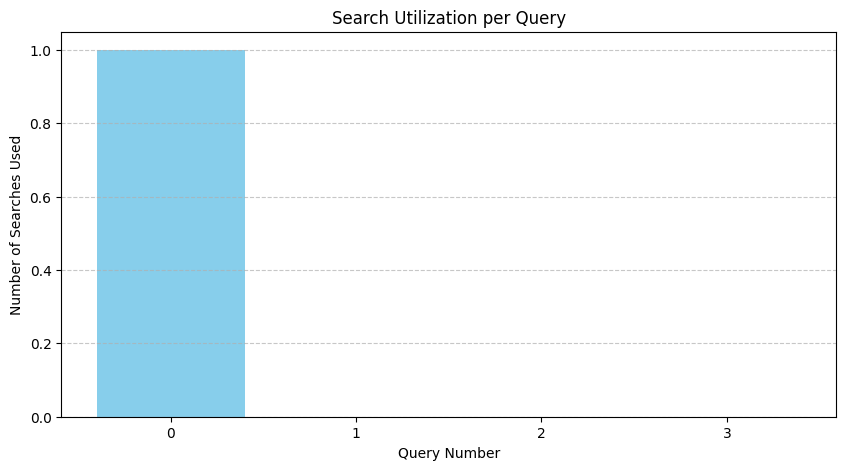


# This advanced workflow demonstrates how to break down complex research questions
# into a structured process that builds deeper insights at each stage.
# Note how the search tool is used differently at each stage of the research process.


In [25]:
# @title ## 9a. Multi-stage Research Workflow with Progressive Refinement
# This advanced workflow demonstrates a structured research process that builds insights progressively

print("\n--- 9a. Multi-stage Research Workflow ---")
print("# This workflow demonstrates how to conduct in-depth research through multiple progressive stages")

def multi_stage_research(research_topic):
    """
    Conduct a multi-stage research process with progressive refinement

    Args:
        research_topic (str): The main research topic or question

    Returns:
        List of responses from each stage
    """
    # Create a new chat with search
    research_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # Store responses for visualization
    responses = []

    # Stage 1: Initial broad exploration
    print(f"\n📊 Stage 1: Initial exploration of '{research_topic}'")
    stage1_prompt = f"""
    I'm conducting research on '{research_topic}'.
    First, provide a broad overview of this topic covering:
    1. Main concepts and terminology
    2. Current state of development
    3. Key players or contributors
    4. Recent major developments

    After providing this overview, identify 3-5 specific subtopics that would be most
    interesting for further in-depth exploration.
    """

    stage1_response = research_chat.send_message(stage1_prompt)
    show_parts(stage1_response)
    responses.append(stage1_response)
    time.sleep(2)

    # Stage 2: Extract subtopics for deeper investigation
    print(f"\n📊 Stage 2: Identifying key subtopics for deeper investigation")
    stage2_prompt = """
    Based on your previous response, extract exactly 3 subtopics that would be most valuable
    to explore further. For each subtopic:
    1. Clearly name the subtopic
    2. Explain why it's particularly significant
    3. Identify specific aspects that need deeper research

    Present these in a clear, structured format.
    """

    stage2_response = research_chat.send_message(stage2_prompt)
    show_parts(stage2_response)
    responses.append(stage2_response)
    time.sleep(2)

    # Stage 3: Deep dive into first subtopic
    print(f"\n📊 Stage 3: Deep dive into first subtopic")
    stage3_prompt = """
    Let's focus on the first subtopic you identified. Please conduct a comprehensive
    deep dive into this specific area. Your analysis should include:

    1. Latest research findings or developments
    2. Key challenges or controversies
    3. Notable innovations or breakthroughs
    4. Future directions and potential impacts
    5. Leading experts, organizations, or companies

    Support your analysis with specific examples, data points, and citations
    from your search results.
    """

    stage3_response = research_chat.send_message(stage3_prompt)
    show_parts(stage3_response)
    responses.append(stage3_response)
    time.sleep(2)

    # Stage 4: Synthesis and insights
    print(f"\n📊 Stage 4: Synthesizing insights and recommendations")
    stage4_prompt = """
    Based on all the research we've conducted so far, please:

    1. Synthesize the key findings into 3-5 major insights
    2. Identify emerging trends or patterns across the research
    3. Note any gaps or contradictions in the current knowledge
    4. Provide recommendations for practical applications of this knowledge
    5. Suggest directions for future research

    Structure this as an executive brief that could inform strategic decision-making.
    """

    stage4_response = research_chat.send_message(stage4_prompt)
    show_parts(stage4_response)
    responses.append(stage4_response)

    # Visualize search usage across the research stages
    print("\n📊 Research Stage Search Utilization:")
    visualize_search_usage(responses)

    return responses

# Run the multi-stage research on a complex topic
research_topic = "Quantum machine learning for drug discovery"
research_results = multi_stage_research(research_topic)

print("\n# This advanced workflow demonstrates how to break down complex research questions")
print("# into a structured process that builds deeper insights at each stage.")
print("# Note how the search tool is used differently at each stage of the research process.")


--- 9b. Competitive Intelligence Framework ---
# Using Gemini's search capabilities to conduct structured competitive analysis

📊 Stage 1: Company profile and market position for Rivian


Okay, I will conduct a comprehensive analysis of Rivian in the Electric Vehicle Manufacturing industry, covering the requested points using factual information from reliable sources.



Here's a comprehensive analysis of Rivian in the Electric Vehicle Manufacturing industry, based on the information gathered from the provided search results:

**1. Company Overview**

*   **History:** Rivian Automotive, Inc. was founded in 2009 by Robert "RJ" Scaringe, initially as Mainstream Motors. The name was later changed to Avera Automotive and finally to Rivian Automotive in 2011.
*   **Size:** As of December 2023, Rivian had 16,790 employees.
*   **Key Offerings:** Rivian designs, develops, manufactures, and sells electric vehicles, accessories, software, and services. Their primary products include:
    *   R1T: A two-row, five-passenger electric pickup truck.
    *   R1S: A three-row, seven-passenger electric SUV.
    *   EDV (Electric Delivery Van): Designed and engineered in collaboration with Amazon.
    *   FleetOS: A centralized fleet management subscription platform.
*   **Facilities:** Rivian is based in Irvine, California. Its primary manufacturing facility is in Normal, Illinois, acquired in 2017. They also have facilities in Palo Alto and Carson, California; Plymouth, Michigan; Burnaby, British Columbia; Wittmann, Arizona; Woking, England; and Belgrade, Serbia. A new $5 billion factory is planned for Georgia, with an expected annual production capacity of 400,000 units.

**2. Current Market Position and Market Share**

*   **Market Position:** Rivian is considered a competitor to Tesla. In Q1 2024, Rivian was the 5th largest EV seller in the US, surpassing BMW, Mercedes-Benz, Chevrolet, and Audi.
*   **Market Share:**
    *   In Q4 2024, the U.S. EV market share was 8.7%. Tesla held 44% of the EV market share in America during this period.
    *   It's important to note that market share is calculated based on total revenue.

**3. Recent Financial Performance and Growth Trends**

*   **Revenue:**
    *   2023: Total revenue was $4.43 billion.
    *   Q4 2024: Revenue reached $1.73 billion, exceeding expectations. This included $299 million from regulatory credits and $214 million from software and services.
*   **Gross Profit/Loss:**
    *   Q4 2024: Rivian reported a gross profit of $170 million.
    *   2023: Negative gross profit of $(2.030) billion, an improvement from $(3.123) billion in 2022.
*   **Net Loss:**
    *   Q4 2023: Net loss was $(1.521) billion.
    *   2023: Net loss was $(5.432) billion, compared to $(6.752) billion in 2022.
    *   Q4 2024: Net loss was $743 million (or 70 cents per share), a significant improvement from the $1.52 billion loss in the same period the previous year.
    *   2024: Rivian posted a $4.75 billion loss.
*   **Production & Deliveries:**
    *   2023: Rivian produced 57,232 vehicles.
    *   2024: Produced 49,476 vehicles and delivered 51,579 vehicles.
    *   Q4 2024: Produced 12,727 and delivered 14,183 vehicles.
*   **Growth Trends:**
    * Rivian's gross margin has increased by 47% YoY and by 44% from the previous quarter.
    * Rivian's gross profit has increased by 41% YoY and by 39% QoQ.
*   **Cash Reserves:** Rivian ended Q4 2023 with $9.368 million in cash, cash equivalents, and short-term investments.
*   **2025 Outlook:** Rivian anticipates lower sales for 2025, forecasting deliveries between 46,000 to 51,000 units. Adjusted losses are expected to narrow to between $1.7 billion and $1.9 billion for 2025, down from a $2.69 billion loss in the previous quarter.
*   **Analyst Expectations:** Analyst predict just 8.3% revenue growth anticipated for 2025, but foresee a potential growth spike in 2026 with the release of mass market vehicles.

**4. Key Executives and Leadership Changes**

*   **Key People:**
    *   RJ Scaringe: Founder and CEO
    *   Claire McDonough: Chief Financial Officer
    *   Javier Varela: Chief Operating Officer (since May 2024)
    *   Jeffrey R Baker: Chief Accounting Officer
    *   Sarah O'Brien: Chief Communications Officer
*   **Leadership Changes:**
    *   Kjell Gruner, Chief Commercial Officer, resigned in July 2024. Dagan Mishoulam was promoted to SVP of commercial.
    *   Jennifer Prenner was hired to lead marketing efforts in 2024.
    *   Javier Varela succeeded Frank Klein as COO in May 2024.
    *   RJ Scaringe assumed direct responsibility for all product functions in November 2023.
    *   Richard Farquhar moved to a new role as SVP of future R&D.
    * Jeffrey Baker, chief accounting officer, resigned in July 2024. Rivian CFO Claire McDonough is serving as the company's interim principal accounting officer.

**5. Recent Strategic Moves**

*   **Partnership with Volkswagen Group:**
    *   In June 2024, Volkswagen Group announced its intention to invest up to $5 billion in Rivian.
    *   The companies launched a joint venture, "Rivian and VW Group Technology, LLC," to develop next-generation electrical architecture and software technology. The total deal size is up to $5.8 billion.
*   **New Product Launches:**
    *   R2 SUV: Unveiled in March 2024, with an expected starting price of around $45,000 and deliveries slated to begin in the first half of 2026.
    *   R3 and R3X: Smaller, more affordable vehicles on the same platform as the R2, with R3 production expected to begin in 2028.
*   **Acquisitions:**
    *   Iternio (A Better Routeplanner - ABRP): Acquired in June 2023 to enhance EV trip planning capabilities.
    *   Manufacturing facility in Normal, Illinois: Acquired in January 2017.
*   **Charging Network:** Plans to build an exclusive charging network in the United States and Canada. As of December 2023, Rivian had 42 service centers.
*   **Charging Standard Adoption:** Rivian will incorporate Tesla's North American Charging System (NACS) into its vehicles in 2025.
*   **Commercial Agreements:** Agreement with Amazon to design, produce, and purchase 100,000 electric delivery vehicles (EDVs).
* **New Company Launch:** Rivian has launched a new company called Also, focused on small electric vehicles like bikes and scooters. The first product is expected to be unveiled in the fall of 2025, with US and European deliveries to follow in 2026.
I have tried to provide the most up-to-date and comprehensive information available as of today, April 1, 2025.



📊 Search Results Used:



📊 Stage 2: Competitor identification and analysis


Okay, I will identify the top 3-5 direct competitors of Rivian and present a structured comparison based on the information available.

Here's a comparative analysis of Rivian's top competitors:

**Top Competitors:**

1.  **Tesla**
2.  **Ford (with F-150 Lightning)**
3.  **General Motors (with Hummer EV and Silverado EV)**
4.  **Lucid Motors**

**Comparative Analysis:**

| Feature                     | Rivian                                                                                                                                                 | Tesla                                                                                                                                                                                             | Ford (F-150 Lightning)                                                                                                                                  | General Motors (Hummer EV & Silverado EV)                                                                                                                                                                                              | Lucid Motors                                                                                                                                             |
| :-------------------------- | :----------------------------------------------------------------------------------------------------------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | :-------------------------------------------------------------------------------------------------------------------------------------------------------- | :--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1. Company Overview**      | Founded in 2009, focuses on electric adventure vehicles (R1T, R1S) and commercial EVs (EDV).                                                         | Founded in 2003, leader in electric vehicles and energy solutions.                                                                                                                            | Traditional automaker, now heavily invested in EVs, including the electric F-150 Lightning.                                                              | Legacy automaker transitioning to EVs, with models like the Hummer EV and Silverado EV.                                                                                                                                                | Founded in 2007, focuses on luxury electric vehicles.                                                                                                    |
| **2. Market Share & Position** | Emerging player, focused on capturing the premium electric truck/SUV market. Q1 2024 was the 5th largest EV seller in the US.                       | Dominant market share in EVs, strong brand recognition. Holds 44% of the EV market share in America as of Q4 2024.                                                                               | Significant early sales of F-150 Lightning, leverages existing truck customer base.                                                                   | Growing presence in the electric truck market, leveraging the Hummer and Silverado brands.                                                                                                                                           | Niche player in the luxury EV market, seeking to establish itself with high-performance vehicles.                                                        |
| **3. Key Differentiators**   | Adventure-focused vehicles, unique design, strong focus on off-road capabilities, partnership with Amazon for EDVs.                                  | Brand recognition, Supercharger network, advanced technology (Autopilot, AI), vertical integration (battery production).                                                                         | Brand recognition (F-150), established dealer network, affordability (compared to Rivian and Hummer EV).                                               | Brand recognition (Hummer, Silverado), extensive dealer network, Ultium battery platform.                                                                                                                                        | Luxury positioning, focus on range and performance, innovative battery technology.                                                                     |
| **4. Recent Strategic Moves**  | Partnership with Volkswagen Group (JV for electrical architecture), launching R2 and R3 models, NACS adoption, acquisition of Iternio (ABRP). Also company launch focused on smaller electric vehicles. | Expanding production capacity (Gigafactories), launching new models (Cybertruck), continued development of autonomous driving technology, NACS adoption. | Scaling up F-150 Lightning production, investing in battery manufacturing, exploring new EV platforms.                                                | Scaling up Hummer EV and Silverado EV production, investing in Ultium battery platform, developing new EV models across various segments.                                                                                            | Focusing on expanding production capacity, launching new models (Gravity SUV), enhancing charging infrastructure.                                       |
| **5. Strengths vs. Rivian**   | N/A                                                                                                                                                    | Brand recognition, established infrastructure, economies of scale, wider product portfolio.                                                                                                       | Established customer base, extensive dealer network, brand loyalty, more affordable options.                                                              | Brand recognition, established manufacturing and distribution network, diverse product portfolio, Ultium platform.                                                                                                                 | High performance, advanced technology, luxury positioning, superior range capabilities.                                                              |
| **Weaknesses vs. Rivian**  | N/A                                                                                                                                                    | Less focused on adventure vehicles, perceived quality issues, reliance on a single CEO, controversial leadership.                                                                                   | Slower transition to EVs, legacy costs, reliance on traditional dealer model, less agile than pure EV players.                                         | Slower transition to EVs, legacy costs, dependence on dealer network, some design choices seen as polarizing (Hummer EV).                                                                                                     | Limited brand recognition, higher price point, smaller scale production.                                                                           |

**Elaborations and Additional Points:**

*   **Tesla:** Tesla's primary advantage remains its established brand, Supercharger network, and economies of scale. Tesla has a wider range of models and price points, making it accessible to a broader customer base. However, Tesla is not directly targeting the adventure vehicle segment as specifically as Rivian.
*   **Ford (F-150 Lightning):** The F-150 Lightning leverages Ford's existing F-150 customer base and dealer network. It offers a more affordable entry point into the electric truck market than Rivian's R1T. However, the Lightning is not as focused on off-road capabilities or the "adventure" lifestyle as Rivian.
*   **General Motors (Hummer EV & Silverado EV):** GM is leveraging its iconic Hummer and Silverado brands to enter the electric truck market. The Hummer EV is a premium, high-performance vehicle, while the Silverado EV aims for a broader customer base. GM's Ultium battery platform is a key competitive advantage.
*   **Lucid Motors:** Lucid is focused on the luxury EV market, competing with Tesla's Model S and potentially the higher-end versions of Rivian's R1S. Lucid's strengths lie in its range and performance, but it faces challenges in scaling production and building brand awareness.
* **Rivian's New Company (Also):** It will be in direct competition with Bird, Lime, and Superpedestrian.

This comparison provides a structured overview of Rivian's competitive landscape. The EV market is dynamic, and these positions may shift as new models are launched, production scales, and consumer preferences evolve.



📊 Stage 3: SWOT analysis for Rivian


Okay, I will conduct a detailed SWOT analysis for Rivian based on the information gathered, covering the points you specified.

**Rivian SWOT Analysis:**

**1. Strengths:** Internal advantages and capabilities

*   **Unique Brand Positioning:** Rivian has successfully carved out a niche in the "adventure vehicle" market, differentiating itself from mainstream EV manufacturers like Tesla. This is evident in the design and capabilities of the R1T and R1S.
*   **Partnership with Amazon:** The collaboration with Amazon for the Electric Delivery Van (EDV) provides a stable revenue stream and valuable real-world testing and development data. This contract guarantees a significant volume of sales.
*   **Innovative Vehicle Design and Technology:** Rivian's vehicles are known for their unique design, robust engineering, and off-road capabilities. The "tank turn" feature on the R1T is a prime example of this innovation.
*   **Strong Leadership (Visionary CEO):** RJ Scaringe's vision and leadership have been crucial in attracting investment, building a strong team, and guiding the company's strategic direction.
*   **Increasing Gross Profit Margin:** Rivian's gross profit margin has increased by 47% YoY and by 44% from the previous quarter.

**2. Weaknesses:** Internal disadvantages or limitations

*   **Production Constraints and Scalability Challenges:** While production is increasing, Rivian still faces challenges in scaling up production to meet demand and achieve profitability. The initial production ramp-up has been slower than anticipated.
*   **High Cash Burn Rate and Financial Losses:** Rivian is still operating at a significant net loss, and its cash burn rate remains high. This requires the company to continue raising capital, which could dilute shareholder value. Rivian posted a $4.75 billion loss in 2024.
*   **Limited Service Infrastructure:** Rivian's service network is still relatively small compared to established automakers like Ford and GM. This could be a disadvantage in terms of customer support and maintenance. Rivian had 42 service centers as of December 2023.
*   **Dependence on Key Suppliers:** Rivian relies on external suppliers for critical components like batteries, which could be a vulnerability if those suppliers face disruptions.
*   **Limited Model Lineup:** Currently, Rivian's product portfolio is limited to the R1T, R1S, and EDV. This limits its ability to appeal to a broader range of customers compared to companies like Tesla or GM.

**3. Opportunities:** External factors that could benefit the company

*   **Growing Demand for Electric Vehicles:** The overall demand for EVs is increasing rapidly, driven by government incentives, environmental concerns, and technological advancements. This provides a large and growing market for Rivian's products.
*   **Expansion into New Markets:** Rivian has the opportunity to expand its sales and operations into new international markets, such as Europe and Asia, to further diversify its revenue streams.
*   **Development of New Products and Services:** Rivian can leverage its technology and brand to develop new products and services, such as battery storage solutions, charging infrastructure, and subscription-based services. Launching of Also indicates a move towards new products, specifically smaller electric vehicles.
*   **Government Incentives and Regulations:** Government policies that promote EV adoption, such as tax credits and emissions regulations, can create a more favorable business environment for Rivian.
*   **Partnerships and Collaborations:** Rivian can further strengthen its position by forming partnerships with other companies, such as technology providers, battery manufacturers, or energy companies. Partnership with Volkswagen Group.

**4. Threats:** External factors that could negatively impact the company

*   **Intense Competition:** The EV market is becoming increasingly competitive, with established automakers and new entrants vying for market share. Tesla, Ford, GM, and other companies are all investing heavily in EVs.
*   **Supply Chain Disruptions:** Global supply chain disruptions, such as shortages of semiconductors or battery materials, could impact Rivian's production and profitability.
*   **Economic Downturn:** An economic recession could reduce consumer spending on discretionary items like vehicles, negatively impacting Rivian's sales.
*   **Changing Government Regulations:** Changes in government policies, such as the reduction or elimination of EV incentives, could reduce demand for Rivian's products.
*   **Technological Advancements by Competitors:** Rapid technological advancements by competitors, such as the development of superior battery technology or autonomous driving systems, could erode Rivian's competitive advantage.



📊 Stage 4: Strategic recommendations


Okay, based on the competitive intelligence gathered, here are strategic recommendations for Rivian, formatted as actionable items that could be presented to executives:

**Strategic Recommendations for Rivian:**

**1. Leverage Identified Strengths:**

*   **Recommendation 1: Amplify Adventure Brand Positioning:** Invest further in marketing and content that reinforces Rivian's "adventure vehicle" brand. Showcase real-world use cases of the R1T and R1S in outdoor activities, off-roading, and exploration.
    *   **Action:** Develop a series of branded content campaigns featuring influencers and customers using Rivian vehicles in adventure settings.
*   **Recommendation 2: Deepen Amazon Partnership & Explore New Commercial Opportunities:** Continue to deliver on the EDV contract with Amazon while also exploring opportunities to adapt the EDV platform for other commercial applications (e.g., delivery services, utilities).
    *   **Action:** Conduct market research to identify potential commercial applications for the EDV platform beyond Amazon.
*   **Recommendation 3: Invest in Differentiating Technology & Features:** Prioritize R&D investments in features that set Rivian apart, such as advanced off-road capabilities, innovative storage solutions, and user-friendly software interfaces.
    *   **Action:** Establish a dedicated innovation team to focus on developing and implementing differentiating technologies and features.
*   **Recommendation 4: Capitalize on Growing Gross Profit Margin:** Rivian can use this momentum to improve operating efficiencies and ensure long-term financial health.
    *   **Action:** Focus on optimizing product processes to continue increasing margins.

**2. Address or Mitigate Weaknesses:**

*   **Recommendation 5: Aggressively Scale Production and Improve Efficiency:** Focus on increasing production capacity at the Normal, Illinois plant and the planned Georgia facility. Implement lean manufacturing principles and optimize the supply chain to reduce costs and improve efficiency.
    *   **Action:** Set specific, measurable, achievable, relevant, and time-bound (SMART) goals for production volume and cost reduction.
*   **Recommendation 6: Secure Additional Funding and Manage Cash Flow:** Explore opportunities to secure additional funding through strategic partnerships, debt financing, or equity offerings. Closely manage cash flow and prioritize investments with the highest potential return.
    *   **Action:** Develop a detailed financial plan outlining funding needs, cash flow projections, and investment priorities.
*   **Recommendation 7: Expand Service Infrastructure Proactively:** Expand the service network by establishing new service centers, mobile service units, and partnerships with independent repair shops. Prioritize areas with high concentrations of Rivian owners.
    *   **Action:** Develop a service network expansion plan based on customer density and demand.
*   **Recommendation 8: Diversify Supply Chain and Build Redundancy:** Identify alternative suppliers for critical components and build redundancy into the supply chain to mitigate the risk of disruptions. Consider vertical integration for key components like battery manufacturing.
    *   **Action:** Conduct a comprehensive supply chain risk assessment and develop mitigation strategies.
*   **Recommendation 9: Broaden Product Lineup:** Accelerate the development and launch of the R2 and R3 models to appeal to a wider range of customers. Consider offering different battery pack options and trim levels to expand the addressable market.
    *   **Action:** Develop a detailed product roadmap outlining the launch timeline and target market for each new model.

**3. Capitalize on Market Opportunities:**

*   **Recommendation 10: Accelerate International Expansion:** Prioritize expansion into key international markets, such as Europe and Asia, by establishing local sales and service operations. Adapt the product lineup to meet local regulations and consumer preferences.
    *   **Action:** Conduct market research to identify the most promising international markets for Rivian.
*   **Recommendation 11: Develop Integrated Energy Solutions:** Leverage Rivian's expertise in batteries and charging technology to develop integrated energy solutions for homes and businesses. Offer solar panel installation, energy storage systems, and smart charging solutions.
    *   **Action:** Establish a dedicated business unit focused on developing and marketing integrated energy solutions.
*   **Recommendation 12: Offer Subscription-Based Services:** Develop subscription-based services for features like advanced driver-assistance systems (ADAS), over-the-air software updates, and vehicle maintenance.
    *   **Action:** Conduct market research to identify the most appealing subscription-based service offerings for Rivian customers.

**4. Defend Against Competitive Threats:**

*   **Recommendation 13: Monitor Competitor Activities and Differentiate Product Offerings:** Continuously monitor the activities of competitors like Tesla, Ford, and GM and differentiate Rivian's product offerings through unique design, performance, and features.
    *   **Action:** Establish a competitive intelligence team to track competitor activities and identify opportunities for differentiation.
*   **Recommendation 14: Strengthen Brand Loyalty and Customer Advocacy:** Invest in building strong relationships with customers and fostering brand loyalty through exceptional customer service, exclusive events, and online communities.
    *   **Action:** Develop a comprehensive customer relationship management (CRM) program to enhance customer engagement and loyalty.
*   **Recommendation 15: Advocate for Favorable Government Policies:** Actively engage with government policymakers to advocate for policies that support EV adoption, such as tax credits, infrastructure investments, and emissions regulations.
    *   **Action:** Establish a government relations team to represent Rivian's interests and advocate for favorable policies.

**5. Potential Areas for Innovation or Market Disruption:**

*   **Recommendation 16: Develop Advanced Battery Technology:** Invest in research and development of advanced battery technology to improve range, charging speed, and energy density. Explore solid-state batteries and other next-generation technologies.
    *   **Action:** Establish a dedicated battery research and development team.
*   **Recommendation 17: Explore Autonomous Driving Capabilities:** Develop advanced autonomous driving capabilities to enhance safety, convenience, and efficiency. Partner with technology companies or develop proprietary solutions.
    *   **Action:** Establish a dedicated autonomous driving development team.
*   **Recommendation 18: Focus on the "Last Mile" Electric Transportation Solutions:** Expand into new market by continuing the Also company launch to develop "last mile" EV products. Focus on providing smaller electric vehicles to address delivery demand.
    *   **Action:** Focus on small electric vehicles such as bikes and scooters.

These strategic recommendations provide a comprehensive roadmap for Rivian to leverage its strengths, address its weaknesses, capitalize on market opportunities, and defend against competitive threats. By implementing these recommendations, Rivian can strengthen its position in the rapidly evolving EV market and achieve long-term success.



📊 Competitive Analysis Search Utilization:


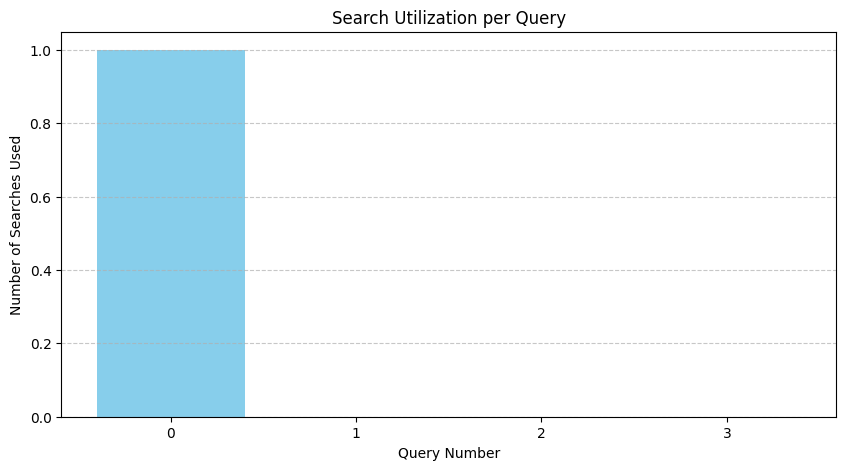


# This framework demonstrates how to use search capabilities for comprehensive competitive analysis
# The structured approach ensures thorough coverage of all aspects of competitive intelligence
# Notice how the search tool grounds the analysis in factual, up-to-date information


In [26]:
# @title ## 9b. Competitive Intelligence Framework
#This workflow demonstrates how to use search for detailed competitive analysis

print("\n--- 9b. Competitive Intelligence Framework ---")
print("# Using Gemini's search capabilities to conduct structured competitive analysis")

def competitive_intelligence_analysis(company_name, industry=None):
    """
    Conduct a structured competitive intelligence analysis for a company

    Args:
        company_name (str): The target company to analyze
        industry (str): Optional industry context

    Returns:
        List of responses from the analysis
    """
    # Create a new chat with search
    competitive_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # Store responses
    responses = []

    # Stage 1: Company profile and market position
    print(f"\n📊 Stage 1: Company profile and market position for {company_name}")
    stage1_prompt = f"""
    Conduct a comprehensive analysis of {company_name}{' in the ' + industry + ' industry' if industry else ''}.

    Include:
    1. Brief company overview (history, size, key offerings)
    2. Current market position and market share if available
    3. Recent financial performance and growth trends
    4. Key executives and leadership changes
    5. Recent strategic moves (acquisitions, partnerships, new product launches)

    Focus on factual information from reliable sources. Include specific numbers
    and metrics wherever possible.
    """

    stage1_response = competitive_chat.send_message(stage1_prompt)
    show_parts(stage1_response)
    responses.append(stage1_response)
    time.sleep(2)

    # Stage 2: Competitor identification and comparison
    print(f"\n📊 Stage 2: Competitor identification and analysis")
    stage2_prompt = f"""
    Identify the top 3-5 direct competitors of {company_name}.

    For each competitor:
    1. Provide a brief company overview
    2. Compare their market share and position to {company_name}
    3. Analyze their key differentiators and competitive advantages
    4. Describe their recent strategic moves
    5. Evaluate their strengths and weaknesses relative to {company_name}

    Present this in a structured comparative format.
    """

    stage2_response = competitive_chat.send_message(stage2_prompt)
    show_parts(stage2_response)
    responses.append(stage2_response)
    time.sleep(2)

    # Stage 3: SWOT analysis
    print(f"\n📊 Stage 3: SWOT analysis for {company_name}")
    stage3_prompt = f"""
    Based on the information gathered, conduct a detailed SWOT analysis for {company_name}:

    1. Strengths: Internal advantages and capabilities
    2. Weaknesses: Internal disadvantages or limitations
    3. Opportunities: External factors that could benefit the company
    4. Threats: External factors that could negatively impact the company

    For each category, provide 4-5 specific points with brief explanations supported by
    the information you've gathered.
    """

    stage3_response = competitive_chat.send_message(stage3_prompt)
    show_parts(stage3_response)
    responses.append(stage3_response)
    time.sleep(2)

    # Stage 4: Strategic recommendations
    print(f"\n📊 Stage 4: Strategic recommendations")
    stage4_prompt = f"""
    Based on all the competitive intelligence gathered, provide strategic recommendations for {company_name}.

    Your recommendations should address:
    1. How to leverage identified strengths
    2. How to address or mitigate weaknesses
    3. How to capitalize on market opportunities
    4. How to defend against competitive threats
    5. Potential areas for innovation or market disruption

    Format these as actionable strategic recommendations that could be presented to executives.
    """

    stage4_response = competitive_chat.send_message(stage4_prompt)
    show_parts(stage4_response)
    responses.append(stage4_response)

    # Visualize search usage across the analysis stages
    print("\n📊 Competitive Analysis Search Utilization:")
    visualize_search_usage(responses)

    return responses

# Run the competitive intelligence analysis on a real company
target_company = "Rivian"
industry = "Electric Vehicle Manufacturing"
competitive_results = competitive_intelligence_analysis(target_company, industry)

print("\n# This framework demonstrates how to use search capabilities for comprehensive competitive analysis")
print("# The structured approach ensures thorough coverage of all aspects of competitive intelligence")
print("# Notice how the search tool grounds the analysis in factual, up-to-date information")

In [27]:
summary = """
## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/
"""

display(Markdown(summary))

print("Thank you for participating in this workshop!")
print("We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.")


## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/


Thank you for participating in this workshop!
We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.
